# Fine-Tuning BERT for:
* Text classification to tell if the news is directly related to Tesla or not
* Sentiment analysis on news

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EvalPrediction

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

## Data Preperation

In [9]:
# read in data with manual labels
df_model = pd.read_csv('../data/Tesla_news_manual_labels.csv', index_col = 0, encoding = 'latin1')
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,yes
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,yes
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,no
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,no
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,yes


In [10]:
df_model.tail()

,source_name,author,date,title,description,content,label,tesla_related
202,TechRadar,Leon Poultney,10/9/2023,Tesla software update can help its car cameras...,Tesla software update 2023.32 brings with it g...,"Reversing into a trashcan, squashing your neig...",positive,yes
203,Breitbart News,"Paul Bois, Paul Bois",10/9/2023,Elon Musk Deletes Several Tweets After Promoti...,Elon Musk deleted several posts on his platfor...,Billionaire and X owner Elon Musk deleted seve...,negative,no
204,Business Insider,Alexa St. John,10/11/2023,Rivian CEO says he wouldn't buy the Cybertruck...,Rivian CEO RJ Scaringe spoke with GQ magazine ...,Carlos Delgado/Associated Press\n<ul><li>Rivia...,neutral,yes
205,Fortune,Prarthana Prakash,10/11/2023,"Bernard Arnault, the world's second richest ma...",LVMH boss Bernard Arnault's wealth topped $200...,Big gains in luxury spending helped LVMH boss ...,neutral,no
206,Reuters,Giulio Piovaccari,10/11/2023,"Ford, Hyundai turn to Italian casting machine ...","Idra, an Italian aluminium casting machine mak...","TRAVAGLIATO, Italy, Oct 11 (Reuters) - Idra, a...",neutral,yes


In [13]:
# check for missing values and data types
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   source_name    207 non-null    object
 1   author         207 non-null    object
 2   date           207 non-null    object
 3   title          207 non-null    object
 4   description    207 non-null    object
 5   content        207 non-null    object
 6   label          207 non-null    object
 7   tesla_related  207 non-null    object
dtypes: object(8)
memory usage: 14.6+ KB


In [15]:
# label and tesla_related were generated manually
# first check if there were any manual errors
df_model.tesla_related.value_counts()

yes    116
no      91
Name: tesla_related, dtype: int64

**Note:** 

Though the number of samples are limited but we have balanced classes for this binary classification.

In [16]:
df_model.label.value_counts()

neutral     84
negative    63
positive    59
neagtive     1
Name: label, dtype: int64

In [26]:
# correct the mannual errors in sentiment analysis labels
df_model['label'] = df_model['label'].replace('neagtive', 'negative')

In [27]:
df_model.label.value_counts()

neutral     84
negative    64
positive    59
Name: label, dtype: int64

**Note:**

Sentiment labels are also balanced, especially between positive and negative.

In [30]:
# next change the labels to numbers
def binary_convert(x):
    if x == 'yes':
        return 1
    else:
        return 0

In [33]:
def sentiment_convert(x):
    if x == 'positive':
        return 1
    elif x == 'negative':
        return -1
    else:
        return 0

In [31]:
df_model['tesla_related'] = df_model['tesla_related'].apply(binary_convert)
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,1
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,1
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,0
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,0
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,1


In [34]:
df_model['sentiment_label'] = df_model['label'].apply(sentiment_convert)
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related,sentiment_label
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,1,0
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,1,-1
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,0,0
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,0,0
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,1,1


In [43]:
# the manual labeling is mainly based on title and description
# create title + description for the classification task
df_model['title_desc'] = df_model['title'].map(str) + ' ' + df_model['description'].map(str)
df_model.head()

,source_name,author,date,title,description,content,label,tesla_related,sentiment_label,title_desc
0,Fortune,Jane Thier,9/12/2023,How Elon Musk lost a friend over AI: Google co...,After Musk tried to sabotage Googles acquisit...,Teslas Elon Musk and Googles Larry Page dont t...,neutral,1,0,How Elon Musk lost a friend over AI: Google co...
1,Next Big Future,Brian Wang,9/12/2023,Bill Gates Tries to Profit by Driving Down Tes...,Bill Gates bet billions against Tesla in a met...,Bill Gates bet billions against Tesla in a met...,negative,1,-1,Bill Gates Tries to Profit by Driving Down Tes...
2,The Jerusalem Post,By REUTERS,9/12/2023,Putin hails Elon Musk as an 'outstanding perso...,The Russian leader said Moscow planned to pers...,Russian President Vladimir Putin on Tuesday ha...,neutral,0,0,Putin hails Elon Musk as an 'outstanding perso...
3,Fortune,Rachyl Jones,9/12/2023,"What do donkeys, dragons and Hawaii have in co...",Musks purchase of Twitter fed his constant ne...,Elon Musk lives for the drama. Thats evident i...,neutral,0,0,"What do donkeys, dragons and Hawaii have in co..."
4,Fortune,Christiaan Hetzner,9/12/2023,Elon Musks supercomputer Dojo added $70 billi...,Elon Musk's Tesla share price has jumped the e...,Teslas gonzo market cap is so enormous that it...,positive,1,1,Elon Musks supercomputer Dojo added $70 billi...


In [35]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 206
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   source_name      207 non-null    object
 1   author           207 non-null    object
 2   date             207 non-null    object
 3   title            207 non-null    object
 4   description      207 non-null    object
 5   content          207 non-null    object
 6   label            207 non-null    object
 7   tesla_related    207 non-null    int64 
 8   sentiment_label  207 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 16.2+ KB


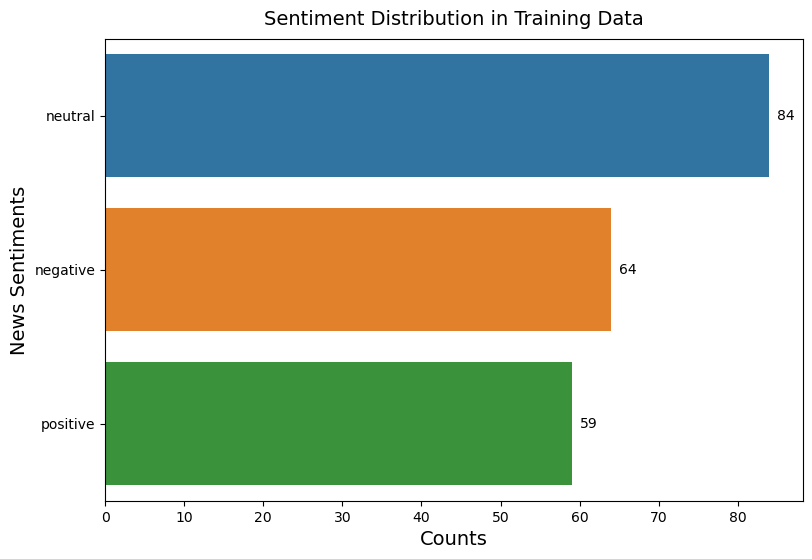

In [104]:
# plot the counts for each label
plt.figure(figsize= (9, 6))

ax = sns.countplot(data = df_model, y = 'label')

for patch in ax.patches:
    width = patch.get_width()
    ax.text(width+1,
            patch.get_y() + patch.get_height() / 2,
            format(width, '1.0f'),
            va = 'center')
plt.title('Sentiment Distribution in Training Data', fontsize = 14, pad = 10)    
plt.ylabel('News Sentiments', fontsize = 14)
plt.xlabel('Counts', fontsize = 14)
plt.show()

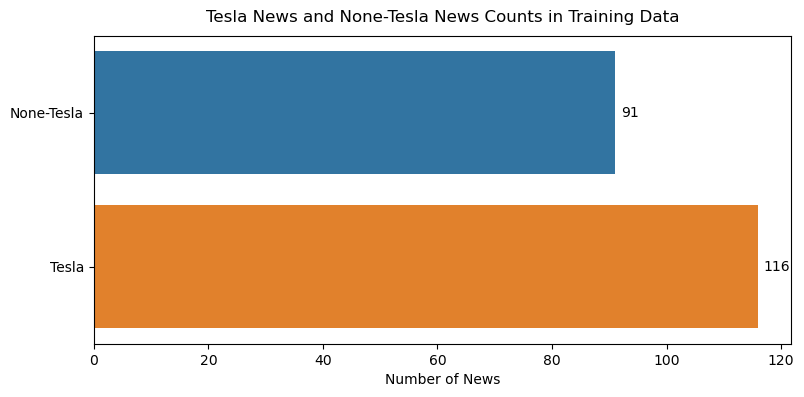

In [100]:
# plot the counts for each label
plt.figure(figsize = (9, 4))

ax = sns.countplot(data = df_model, y = 'tesla_related')

for patch in ax.patches:
    width = patch.get_width()
    ax.text(width + 1,
            patch.get_y() + patch.get_height() / 2,
            format(width, '1.0f'),
            va = 'center')

plt.title('Tesla News and None-Tesla News Counts in Training Data', pad = 10)    
plt.yticks([0, 1], ['None-Tesla', 'Tesla'])
plt.ylabel(None)
plt.xlabel('Number of News')
plt.show()

## Train / Validation Split

In [46]:
# randomize the data before splitting
df_train = df_model[['title_desc', 'tesla_related', 'sentiment_label']].sample(n = int(df_model.shape[0]*0.8), random_state = 21)
df_val = df_model[['title_desc', 'tesla_related', 'sentiment_label']].drop(df_train.index)
df_train.shape, df_val.shape

((165, 3), (42, 3))

In [47]:
df_train.sentiment_label.value_counts()

 0    67
-1    53
 1    45
Name: sentiment_label, dtype: int64

In [48]:
df_val.sentiment_label.value_counts()

 0    17
 1    14
-1    11
Name: sentiment_label, dtype: int64

In [49]:
df_train.tesla_related.value_counts()

1    96
0    69
Name: tesla_related, dtype: int64

In [50]:
df_val.tesla_related.value_counts()

0    22
1    20
Name: tesla_related, dtype: int64

In [58]:
df_train.head()

,title_desc,tesla_related,sentiment_label
111,AOC says she's looking to trade in her Tesla f...,1,-1
17,"Mercedes-Benz's $100,000 electric SUV is an aw...",1,0
116,Where is the phone?' Huawei keeps quiet about ...,1,0
6,Elon Musk sent a graphic mid-childbirth pictur...,0,0
9,Did Elon Musk Turn Off Starlink for Ukraine? W...,0,0


In [59]:
df_val.head()

,title_desc,tesla_related,sentiment_label
4,Elon Musks supercomputer Dojo added $70 billi...,1,1
5,Elon Musk's biographer says Musk has 'multiple...,0,0
12,Elon Musk biography contains inaccurate tale o...,0,0
15,During the most concentrated pain in his lif...,1,1
18,Tesla Semi Shows Real World Payload and Range ...,1,1


## Pytorch Dataset

Trainer using Pytorch for fine-tuning BERT, the input data need to be prepared in Pytorch way.

`torch.utils.data.Dataset` class sotres samples for modeling

`torch.utils.data.DataLoader` class enable iterative access to `Dataset` class samples

In [116]:
# create a pytorch dataset class
class BertDataset(Dataset):
    # initialze the pytorch dataset object with input parameters
    def __init__(self, news, labels, tokenizer):
        self.news = news
        self.labels = labels
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length # use the max length supported by BERT model which is 512
    # returns the number of samples
    def __len__(self):
        return len(self.news)
    # loads and returns a sample from the dataset at a given index
    def __getitem__(self, index):
        content = str(self.news[index])
        label = self.labels[index]
        # encode the news using the input tokenizer
        encoded_news = self.tokenizer.encode_plus(
            content,
            add_special_tokens    = True,
            max_length            = self.max_len,
            return_token_type_ids = False,
            return_attention_mask = True,
            return_tensors        = "pt",
            padding               = "max_length",
            truncation            = True
        )
        # output the input_id, the attention_mask and the corresponding label in input
        return {
            'input_ids': encoded_news['input_ids'][0],
            'attention_mask': encoded_news['attention_mask'][0],
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [57]:
# load tokenizer from BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

C:\Users\wfei2\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\wfei2\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Task Defination:
* Task 1: Binary classification for Tesla related or not
* Task 2: Sentiment analysis for all news

# Task 1

In [152]:
# create datasets
train1_dataset = BertDataset(
    news = df_train.title_desc.tolist(), 
    labels = df_train.tesla_related.tolist(), 
    tokenizer = tokenizer)

In [118]:
val1_dataset = BertDataset(
    news = df_val.title_desc.tolist(), 
    labels = df_val.tesla_related.tolist(), 
    tokenizer = tokenizer)

In [153]:
# create dataloader in order to pass samples as minibatches for training
train1_dataloader = DataLoader(train1_dataset, batch_size = 16, shuffle = True)
val1_dataloader = DataLoader(val1_dataset, batch_size = 16, shuffle = True)

In [154]:
# let's check an example sample in the dataloader
sample = next(iter(train1_dataloader))
input_ids_sample = sample['input_ids']
attention_mask_sample = sample['attention_mask']
labels_sample = sample['labels']

In [155]:
input_ids_sample.shape, attention_mask_sample.shape, labels_sample.shape

(torch.Size([16, 512]), torch.Size([16, 512]), torch.Size([16]))

In [156]:
# check for encoded text
input_ids_sample[0]

tensor([  101, 25983,  2003, 11991,  2000, 26060,  1011,  2806,  6583,  6169,
        13354,  2015,  2005,  2049, 23408,  2015,  1999,  2397, 16798,  2549,
        25983, 23408,  2015,  2008,  2145,  2031,  1996, 10507,  2015,  2487,
        13354,  2097,  2131,  3229,  1999, 16798,  2629,  2007,  2019, 15581,
         2121,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [157]:
# check for attention mask
# you can tell the attention mask distinguish actual tokens or just padding tokens
attention_mask_sample[0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [158]:
# check for label
labels_sample

tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0])

## Trainer from Huggingface Transformers

[Learn more about Trainer package](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer)

From the Huggingface Transformers docs: "Trainer is a simple but feature-complete training and eval loop for PyTorch, optimized for Transformers."

### Load Model and Freeze Parameters

In [142]:
# load the model
bert_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [144]:
# freeze the whole BERT model and only train the last classification layer
for name, param in bert_model.bert.named_parameters():
    param.requires_grad = False

### Compute Metrics

In [174]:
# define computing metrics for training
def binary_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    accuracy = accuracy_score(labels, preds)
    return {
        'f1': f1,
        'accuracy': accuracy,
        'rocauc': roc_auc
    }

In [206]:
# print out the metrics during evaluation
def compute_metrics(p:EvalPrediction):
    return binary_metrics(p)

### Define Training

In [207]:
# define training arguments
train_args = TrainingArguments(
    output_dir = './binary_training_results',  # where the model predictions and checkpoints will be written to
    overwrite_output_dir = True,
    evaluation_strategy = "epoch",  # evaluation is done at the end of each epoch.
    per_device_train_batch_size = 4,  # batch size per core
    per_device_eval_batch_size = 4,  # batch size per core
    # optimizer related parameters
    learning_rate = 2e-5,
    weight_decay = 0.01,
    num_train_epochs = 5,  # total number of training epochs
    save_strategy = "epoch",  # save at the end of each epoch
    load_best_model_at_end = True,  # the best checkpoint will always be saved at the end
    metric_for_best_model = 'loss',  # use eval_loss to find the best model
    greater_is_better = False,  # smaller eval_loss is better
) 

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [208]:
# define the trainer
trainer = Trainer(
    model = bert_model,
    args = train_args,
    train_dataset = train1_dataset,
    eval_dataset = val1_dataset,
    compute_metrics = compute_metrics 
)

### Start Training

In [209]:
trainer.train()

C:\Users\wfei2\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 165
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 210
  Number of trainable parameters = 1538


Epoch,Training Loss,Validation Loss,F1,Accuracy,Rocauc
1,No log,0.690832,0.166667,0.523810,0.504545
2,No log,0.686404,0.555556,0.428571,0.443182
3,No log,0.686621,0.655738,0.500000,0.522727
4,No log,0.686904,0.655738,0.500000,0.522727
5,No log,0.686505,0.655738,0.500000,0.522727


***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./binary_training_results\checkpoint-42
Configuration saved in ./binary_training_results\checkpoint-42\config.json
Model weights saved in ./binary_training_results\checkpoint-42\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./binary_training_results\checkpoint-84
Configuration saved in ./binary_training_results\checkpoint-84\config.json
Model weights saved in ./binary_training_results\checkpoint-84\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./binary_training_results\checkpoint-126
Configuration saved in ./binary_training_results\checkpoint-126\config.json
Model weights saved in ./binary_training_results\checkpoint-126\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 42
  Batch size = 4
Saving model checkpoint to ./binary_training_results\che

TrainOutput(global_step=210, training_loss=0.6918074108305432, metrics={'train_runtime': 54274.1063, 'train_samples_per_second': 0.015, 'train_steps_per_second': 0.004, 'total_flos': 217066620672000.0, 'train_loss': 0.6918074108305432, 'epoch': 5.0})

<span style='color:red'>**Summary: The accuracy of the model is almost same as random guess.**<span>

* Sample size is possible too small to fine-tuning the model.
* BERT is not appropriate for this type of text classification task.

### test to find out the model prediction output format

In [189]:
# create datasets
train1_small = BertDataset(
    news = df_train.iloc[0:8, 0].tolist(), 
    labels = df_train.iloc[0:8, 1].tolist(), 
    tokenizer = tokenizer)

In [191]:
len(df_train.iloc[0:8, 1].tolist())

8

In [187]:
df_train.head()

,title_desc,tesla_related,sentiment_label
111,AOC says she's looking to trade in her Tesla f...,1,-1
17,"Mercedes-Benz's $100,000 electric SUV is an aw...",1,0
116,Where is the phone?' Huawei keeps quiet about ...,1,0
6,Elon Musk sent a graphic mid-childbirth pictur...,0,0
9,Did Elon Musk Turn Off Starlink for Ukraine? W...,0,0


In [192]:
# define the trainer
trainer1 = Trainer(
    model = bert_model,
    args = train_args,
    compute_metrics = binary_metrics 
)

In [193]:
bert_train1_output = trainer1.predict(train1_small)

***** Running Prediction *****
  Num examples = 8
  Batch size = 4


In [194]:
type(bert_train1_output)

transformers.trainer_utils.PredictionOutput

In [195]:
bert_train1_output

PredictionOutput(predictions=array([[0.7284382 , 0.16914575],
       [0.8083266 , 0.20289971],
       [0.38745153, 0.08549518],
       [0.5581102 , 0.13084072],
       [0.5385788 , 0.37167233],
       [0.78016263, 0.32706472],
       [0.5805494 , 0.26181558],
       [0.7916084 , 0.29966637]], dtype=float32), label_ids=array([1, 1, 1, 0, 0, 1, 1, 0], dtype=int64), metrics={'test_loss': 0.7888289093971252, 'test_f1': 0.0, 'test_accuracy': 0.375, 'test_rocauc': 0.5, 'test_runtime': 400.9993, 'test_samples_per_second': 0.02, 'test_steps_per_second': 0.005})

In [ ]:
# define computing metrics for training
def binary_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    accuracy = accuracy_score(labels, preds)
    return {
        'f1': f1,
        'accuracy': accuracy,
        'rocauc': roc_auc
    }

In [196]:
bert_train1_output.label_ids

array([1, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

In [199]:
bert_train1_output.predictions

array([[0.7284382 , 0.16914575],
       [0.8083266 , 0.20289971],
       [0.38745153, 0.08549518],
       [0.5581102 , 0.13084072],
       [0.5385788 , 0.37167233],
       [0.78016263, 0.32706472],
       [0.5805494 , 0.26181558],
       [0.7916084 , 0.29966637]], dtype=float32)

In [200]:
bert_train1_output.predictions.argmax(-1)

array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)